In [7]:
from scipy.stats import fisher_exact
import pandas as pd
import numpy as np
from statsmodels.stats.multitest import multipletests
from matplotlib import pyplot as plt
from tqdm import tqdm
import matplotlib.lines as mlines

def simulate_abundance(hmdb_list, mean=100, std=20):
    np.random.seed(42)
    abundances = np.random.normal(mean, std, len(hmdb_list))
    abundances = np.maximum(abundances, 0)
    return pd.DataFrame({'HMDB_ID': hmdb_list, 'Abundance': abundances})


entities=pd.read_csv("../data/extract_data/metakg_entities.csv")
triples=pd.read_csv("../data/extract_data/metakg_triples.csv")
hmdb_list=['hmdb_id:HMDB0001308','hmdb_id:HMDB0062800','hmdb_id:HMDB0001341','hmdb_id:HMDB0000208','hmdb_id:HMDB0062424','hmdb_id:HMDB0014559','hmdb_id:HMDB0000168','hmdb_id:HMDB0000191','hmdb_id:HMDB0000538','hmdb_id:HMDB0000562','hmdb_id:HMDB0000082','hmdb_id:HMDB0001532','hmdb_id:HMDB0000998','hmdb_id:HMDB0000012','hmdb_id:HMDB0001112','hmdb_id:HMDB0001473','hmdb_id:HMDB0001068','hmdb_id:HMDB0001342','hmdb_id:HMDB0001409','hmdb_id:HMDB0001058','hmdb_id:HMDB0001049','hmdb_id:HMDB0001201','hmdb_id:HMDB0008327','hmdb_id:HMDB0001397','hmdb_id:HMDB0003379','hmdb_id:HMDB0015536','hmdb_id:HMDB0000172','hmdb_id:HMDB0000156','hmdb_id:HMDB0002108','hmdb_id:HMDB0001138','hmdb_id:HMDB0006029','hmdb_id:HMDB0011745','hmdb_id:HMDB0001487','hmdb_id:HMDB0000217','hmdb_id:HMDB0000828','hmdb_id:HMDB0250791','hmdb_id:HMDB0001489','hmdb_id:HMDB0000618','hmdb_id:HMDB0029418','hmdb_id:HMDB0060274','hmdb_id:HMDB0000251','hmdb_id:HMDB0000295','hmdb_id:HMDB0000286','hmdb_id:HMDB0000290','hmdb_id:HMDB0000285',"hmdb_id:HMDB0000094","hmdb_id:HMDB0001112","hmdb_id:HMDB0001068","hmdb_id:HMDB0001058","hmdb_id:HMDB0000172","hmdb_id:HMDB0001138","hmdb_id:HMDB0000812","hmdb_id:HMDB0006029","hmdb_id:HMDB0001015","hmdb_id:HMDB000148","hmdb_id:HMDB0000618","hmdb_id:HMDB0060274"]
hmdb_abundance = simulate_abundance(hmdb_list)
select_relations = ['has_pathway', 'has_disease', 'has_reference', 'has_tissue_location']
num_relations_to_select = 10

In [9]:
def create_mesa_plot(triples, hmdb_abundance, select_relations, num_relations_to_select):
    common_smpdb = pd.read_csv("./SMPDB_table.csv")["pathway_id"].apply(lambda x:"pathway_id:"+x).tolist()
    pathway_triples = triples[(triples["Relationship"] == "has_pathway") & (triples["Head"].str.contains("HMDB"))]
    total_hmdb_set = set(pathway_triples[pathway_triples["Tail"].isin(common_smpdb)]["Head"].unique())
    hmdb_set = set(hmdb_abundance['HMDB_ID']) & total_hmdb_set
    total_hmdb_num = len(total_hmdb_set)
    sample_hmdb_num = len(hmdb_set)

    # Define color dictionary
    color_dict = {
        "has_pathway": "#F48346",
        "has_disease": "#F9A339",
        "has_reference": "#D27CBE",
        "has_tissue_location": "#639E9C"
    }

    def perform_mesa(relation):
        output = []
        print(f"Processing relation: {relation}")
        relation_triples = triples[(triples["Relationship"] == relation) & (triples["Head"].str.contains("HMDB"))]
        hmdb_list_relation_triples = relation_triples[relation_triples["Head"].isin(hmdb_set)]

        tail_counts = hmdb_list_relation_triples["Tail"].value_counts()
        head_sets = relation_triples.groupby("Tail")["Head"].apply(set)
        
        for item, sample_correct_hmdb_num in tqdm(tail_counts.items(), total=len(tail_counts)):
            item_hmdb_set = head_sets[item]
            total_correct_hmdb_num = len(total_hmdb_set & item_hmdb_set)
            
            # Compute MESA score
            sample_abundance = hmdb_abundance[hmdb_abundance['HMDB_ID'].isin(item_hmdb_set & hmdb_set)]['Abundance'].sum()
            total_abundance = hmdb_abundance['Abundance'].sum()
            
            mesa_score = (sample_abundance / total_abundance) / (total_correct_hmdb_num / total_hmdb_num)
            
            # Compute p-value using Fisher's exact test
            contingency_table = [
                [sample_correct_hmdb_num, sample_hmdb_num - sample_correct_hmdb_num],
                [total_correct_hmdb_num - sample_correct_hmdb_num, total_hmdb_num - total_correct_hmdb_num - (sample_hmdb_num - sample_correct_hmdb_num)]
            ]
            _, p_value = fisher_exact(contingency_table)
            
            output.append([item, p_value, total_hmdb_num, total_correct_hmdb_num, 
                        total_correct_hmdb_num / total_hmdb_num * sample_hmdb_num,
                        sample_hmdb_num, sample_correct_hmdb_num, mesa_score, relation])
        
        df = pd.DataFrame(output, columns=["MESA Results", "P-Value", "Total", "Total Hits",
                                        "Expected", "Sample", "Sample Hits", "MESA Score", "Category"])
        df["P-Value"] = df["P-Value"].fillna(1)
        df["-Log10-p"] = -np.log10(df["P-Value"])

        _, df["Holm adjust"], _, _ = multipletests(df["P-Value"], method="holm")
        df["Reject Null Hypothesis"] = df["P-Value"] <= 0.05

        _, df["FDR"], _, _ = multipletests(df["P-Value"], method="fdr_bh")
        _, df["Q-Value"], _, _ = multipletests(df["P-Value"], method="fdr_bh")

        df = df[(df["Reject Null Hypothesis"]) & (df["Total Hits"] >= 2)]
        df_sorted = df.nlargest(num_relations_to_select, "-Log10-p")
        return df_sorted

    df_list = [perform_mesa(relation) for relation in select_relations]
    df_sorted = pd.concat(df_list)

    fig, ax = plt.subplots(figsize=(8, 12))

    for category in df_sorted["Category"].unique():
        subset = df_sorted[df_sorted["Category"] == category]
        scatter = ax.scatter(subset["MESA Score"], 
                            subset["MESA Results"].apply(lambda x: x[:30]), 
                            s=subset["Sample Hits"] * 50, 
                            alpha=-np.log10(subset["P-Value"])/ np.max(-np.log10(subset["P-Value"])),
                            color=color_dict[category], 
                            edgecolors="grey", 
                            linewidth=1, 
                            label=category)

    ax.set_xlabel("MESA Score", fontsize=12)
    ax.set_ylabel("MESA Results", fontsize=12)

    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=category,
                                markerfacecolor=color, markersize=10)
                    for category, color in color_dict.items()]

    category_legend = ax.legend(handles=legend_elements, title="Category", 
                                title_fontsize=12, fontsize=10, loc='upper right')

    ax.add_artist(category_legend)

    size_legend_elements = [
        plt.scatter([], [], s=25*5, c='gray', alpha=0.7, label='5'),
        plt.scatter([], [], s=25*10, c='gray', alpha=0.7, label='10'),
        plt.scatter([], [], s=25*15, c='gray', alpha=0.7, label='15')
    ]

    size_legend = ax.legend(handles=size_legend_elements, 
                            title="Sample Hits", 
                            title_fontsize=12, 
                            fontsize=10, 
                            loc='upper right', 
                            bbox_to_anchor=(1, 0.16), 
                            labelspacing=1,
                            ncol=3,
                            columnspacing=1) 

    ax.add_artist(size_legend)

    alpha_legend_elements = [
        mlines.Line2D([], [], color='gray', marker='o', linestyle='None', markersize=10, alpha=0.3, label='Low'),
        mlines.Line2D([], [], color='gray', marker='o', linestyle='None', markersize=10, alpha=0.7, label='Medium'),
        mlines.Line2D([], [], color='gray', marker='o', linestyle='None', markersize=10, alpha=1.0, label='High')
    ]

    alpha_legend = ax.legend(handles=alpha_legend_elements, title="-log10(p-value)", title_fontsize=12, fontsize=10, 
                            loc='upper right', bbox_to_anchor=(1, 0.1))

    ax.add_artist(alpha_legend)

    plt.tight_layout()
    plt.savefig("mesa_plot.png", dpi=300)
    plt.show()
    return df_sorted

Processing relation: has_pathway


100%|██████████| 48576/48576 [00:19<00:00, 2454.99it/s]


Processing relation: has_disease


100%|██████████| 90/90 [00:00<00:00, 1721.10it/s]


Processing relation: has_reference


100%|██████████| 449/449 [00:00<00:00, 2162.90it/s]


Processing relation: has_tissue_location


100%|██████████| 25/25 [00:00<00:00, 1463.18it/s]


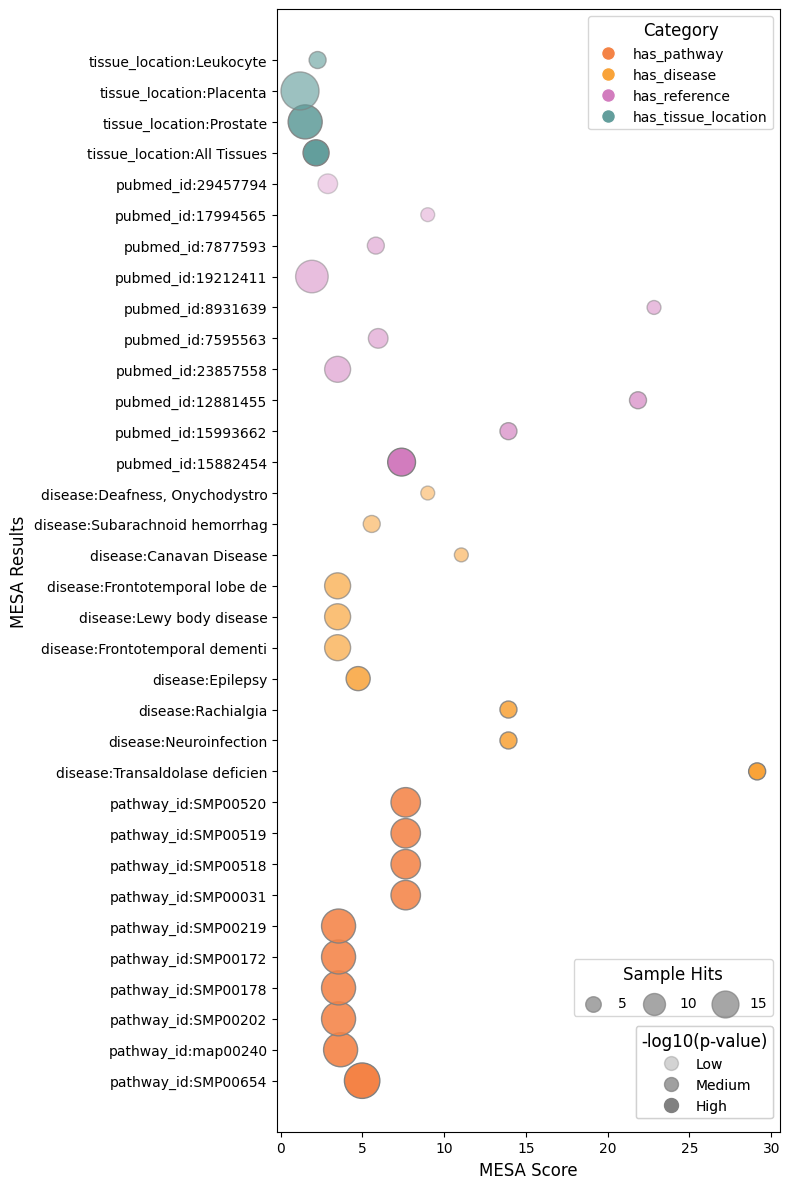

,MESA Results,P-Value,Total,Total Hits,Expected,Sample,Sample Hits,MESA Score,Category,-Log10-p,Holm adjust,Reject Null Hypothesis,FDR,Q-Value
0,pathway_id:SMP00654,9.313187e-09,1024,60,1.992188,34,13,4.985972,has_pathway,8.030902,0.000452,True,0.000452,0.000452
5,pathway_id:map00240,5.891661e-08,1024,57,1.892578,34,12,3.669598,has_pathway,7.229762,0.002862,True,0.000493,0.000493
1,pathway_id:SMP00202,8.941258e-08,1024,59,1.958984,34,12,3.545205,has_pathway,7.048601,0.004343,True,0.000493,0.000493
2,pathway_id:SMP00178,8.941258e-08,1024,59,1.958984,34,12,3.545205,has_pathway,7.048601,0.004343,True,0.000493,0.000493
3,pathway_id:SMP00172,8.941258e-08,1024,59,1.958984,34,12,3.545205,has_pathway,7.048601,0.004343,True,0.000493,0.000493
4,pathway_id:SMP00219,8.941258e-08,1024,59,1.958984,34,12,3.545205,has_pathway,7.048601,0.004343,True,0.000493,0.000493
26,pathway_id:SMP00031,1.015851e-07,1024,29,0.962891,34,9,7.651268,has_pathway,6.993170,0.004934,True,0.000493,0.000493
31,pathway_id:SMP00518,1.015851e-07,1024,29,0.962891,34,9,7.651268,has_pathway,6.993170,0.004934,True,0.000493,0.000493
32,pathway_id:SMP00519,1.015851e-07,1024,29,0.962891,34,9,7.651268,has_pathway,6.993170,0.004934,True,0.000493,0.000493
35,pathway_id:SMP00520,1.015851e-07,1024,29,0.962891,34,9,7.651268,has_pathway,6.993170,0.004934,True,0.000493,0.000493


In [10]:
create_mesa_plot(triples, hmdb_abundance, select_relations, num_relations_to_select)